In this notebook I will try to build a simple transformer model for french to english translation. <br>
The goal is to export the model so everything will be done using tensorflow text processing instead of nltk. <br>
I'm not going to pretend that I did everything myself, this is basically a copy of the excellent notebook on portuguese to english translation from the tensorflow website: https://www.tensorflow.org/text/tutorials/transformer <br>
And the text processing part is taken from the subword tokenizer notebook: https://www.tensorflow.org/text/guide/subwords_tokenizer <br>
The position embedding comes from the  Deep Learning Specialization of DeepLearning.AI. <br>
The first version is not very interesting as it is mainly copy and pasted from the tensorflow wesite, but I hope to be abble to tweak it to improve it, and of course to be abble to use it for other application than text translation. <br>

# Text processing

In [2]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('eng_-french.csv', nrows=None)
data = data.dropna()
data.columns = ['en', 'fr']

In [4]:
data.head()

,en,fr
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      175621 non-null  object
 1   fr      175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [6]:
context_raw = data['fr'].to_numpy()
target_raw = data['en'].to_numpy()

In [7]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b"Tom n'enleva pas son manteau." b'Sais-tu lire \xc3\xa7a ?'
 b'Est-ce que tu vas nous aider demain matin\xc2\xa0?'
 b"As-tu essay\xc3\xa9 de red\xc3\xa9marrer l'ordinateur ?"
 b'Quel est votre type, exactement ?'], shape=(5,), dtype=string)

tf.Tensor(
[b"Tom didn't take off his coat." b'Can you read that?'
 b'Are you going to help us tomorrow morning?'
 b'Did you try restarting the computer?' b'What is your type exactly?'], shape=(5,), dtype=string)


In [9]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, "[^ a-zà-ÿ.?!,'-]", "")
    #text = tf.strings.regex_replace(text, "[^ a-zà-ÿ.?!,'-]", "")
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, "[.?!,']", r" \0 ")
    #replace "-" by a space 
    text = tf.strings.regex_replace(text, "[-]", " ")
    # Strip whitespace.
    text = tf.strings.strip(text)

    #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [10]:
#clean the french en english sentences
def clean_text(context,target):
    context = tf_lower_and_split_punct(context)
    target = tf_lower_and_split_punct(target)
    return context, target

In [11]:
train_ds = train_raw.map(clean_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(clean_text, tf.data.AUTOTUNE)

In [12]:
for example_context_strings, example_target_strings in train_ds.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'je ne pourrai jamais faire ca sans ton aide .'
 b'utilisez vous un apres rasage  ?'
 b'tom peut courir plus vite que moi .'
 b"je pense que nous devrions tous aller a l ' interieur ."
 b"tu ne crois pas tom ,  n ' est ce pas  ?"], shape=(5,), dtype=string)

tf.Tensor(
[b"i ' ll never be able to do that without your help ."
 b'do you use aftershave ?' b'tom can run faster than i can .'
 b'i think we should all go inside .'
 b"you don ' t believe tom ,  do you ?"], shape=(5,), dtype=string)


In [13]:
example_text = tf.constant('Pourquoi ne répondez-vous pas ?')

print(example_text.numpy())
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy())
print(tf_lower_and_split_punct(example_text).numpy().decode())

b'Pourquoi ne r\xc3\xa9pondez-vous pas ?'
Pourquoi ne répondez-vous pas ?
b'pourquoi ne repondez vous pas  ?'
pourquoi ne repondez vous pas  ?


In [14]:
max_vocab_size = 15000

In [15]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = max_vocab_size,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [16]:
train_fr = train_ds.map(lambda fr, en:fr)
train_en = train_ds.map(lambda fr, en:en)

In [17]:
%%time
fr_vocab = bert_vocab.bert_vocab_from_dataset(
    train_fr.unbatch().batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 48.6 s, sys: 186 ms, total: 48.7 s
Wall time: 46.3 s


In [18]:
len(fr_vocab)

5982

In [19]:
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.unbatch().batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 29 s, sys: 159 ms, total: 29.1 s
Wall time: 26.8 s


In [20]:
len(en_vocab)

4577

In [21]:
def write_vocab_file(filepath, vocab):
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [22]:
write_vocab_file('fr_vocab.txt', fr_vocab)
write_vocab_file('en_vocab.txt', en_vocab)

In [23]:
fr_tokenizer = tf_text.BertTokenizer('fr_vocab.txt', **bert_tokenizer_params)
en_tokenizer = tf_text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

In [24]:
for fr_examples, en_examples in train_ds.unbatch().batch(3).take(1):
    for ex, fr in zip(en_examples, fr_examples):
        print(ex.numpy(), fr.numpy())

b'how many children do you have ?' b"combien d ' enfants avez vous  ?"
b'tom and mary were both suspects .' b'tom et marie etaient tous deux suspects .'
b'i want a status report .' b'je veux un rapport de situation .'


In [25]:
# Tokenize the examples -> (batch, word, word-piece)
token_batch = en_tokenizer.tokenize(en_examples)
# Merge the word and word-piece axes -> (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

for ex in token_batch.to_list():
    print(ex)

[72, 170, 270, 43, 35, 49, 8]
[40, 79, 106, 87, 320, 1748, 82, 7]
[17, 61, 9, 27, 506, 1176, 1285, 698, 7]


In [26]:
# Lookup each token id in the vocabulary.
txt_tokens = tf.gather(en_vocab, token_batch)
# Join with spaces.
tf.strings.reduce_join(txt_tokens, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'how many children do you have ?',
       b'tom and mary were both suspect ##s .',
       b'i want a s ##t ##at ##us report .'], dtype=object)>

In [27]:
# Tokenize the examples -> (batch, word, word-piece)
token_batch = fr_tokenizer.tokenize(fr_examples)
# Merge the word and word-piece axes -> (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

for ex in token_batch.to_list():
    print(ex)

[168, 12, 5, 220, 83, 39, 8]
[47, 82, 216, 314, 120, 140, 2346, 60, 7]
[35, 69, 48, 765, 36, 712, 7]


In [28]:
# Lookup each token id in the vocabulary.
txt_tokens = tf.gather(fr_vocab, token_batch)
# Join with spaces.
tf.strings.reduce_join(txt_tokens, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b"combien d ' enfants avez vous ?",
       b'tom et marie etaient tous deux suspect ##s .',
       b'je veux un rapport de situation .'], dtype=object)>

In [29]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
    count = ragged.bounding_shape()[0]
    starts = tf.fill([count,1], START)
    ends = tf.fill([count,1], END)
    return tf.concat([starts, ragged, ends], axis=1)

def cleanup_text(reserved_tokens, token_txt):
    # Drop the reserved tokens, except for "[UNK]".
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
    bad_token_re = "|".join(bad_tokens)

    bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
    result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

    # Join them into strings.
    result = tf.strings.reduce_join(result, separator=' ', axis=-1)

    return result

In [30]:
class CustomTokenizer(tf.Module):
    def __init__(self, reserved_tokens, vocab_path):
        self.tokenizer = tf_text.BertTokenizer(vocab_path, lower_case=True)
        self._reserved_tokens = reserved_tokens
        self._vocab_path = tf.saved_model.Asset(vocab_path)

        vocab = pathlib.Path(vocab_path).read_text().splitlines()
        self.vocab = tf.Variable(vocab)

        ## Create the signatures for export:   

        # Include a tokenize signature for a batch of strings. 
        self.tokenize.get_concrete_function(
            tf.TensorSpec(shape=[None], dtype=tf.string))

        # Include `detokenize` and `lookup` signatures for:
        #   * `Tensors` with shapes [tokens] and [batch, tokens]
        #   * `RaggedTensors` with shape [batch, tokens]
        self.detokenize.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))
        self.detokenize.get_concrete_function(
              tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

        self.lookup.get_concrete_function(
            tf.TensorSpec(shape=[None, None], dtype=tf.int64))
        self.lookup.get_concrete_function(
              tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

        # These `get_*` methods take no arguments
        self.get_vocab_size.get_concrete_function()
        self.get_vocab_path.get_concrete_function()
        self.get_reserved_tokens.get_concrete_function()

    @tf.function
    def tokenize(self, strings):
        enc = self.tokenizer.tokenize(strings)
        # Merge the `word` and `word-piece` axes.
        enc = enc.merge_dims(-2,-1)
        enc = add_start_end(enc)
        return enc

    @tf.function
    def detokenize(self, tokenized):
        words = self.tokenizer.detokenize(tokenized)
        return cleanup_text(self._reserved_tokens, words)

    @tf.function
    def lookup(self, token_ids):
        return tf.gather(self.vocab, token_ids)

    @tf.function
    def get_vocab_size(self):
        return tf.shape(self.vocab)[0]

    @tf.function
    def get_vocab_path(self):
        return self._vocab_path

    @tf.function
    def get_reserved_tokens(self):
        return tf.constant(self._reserved_tokens)

In [31]:
tokenizers = tf.Module()
tokenizers.fr = CustomTokenizer(reserved_tokens, 'fr_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

In [32]:
model_name = 'ted_hrlr_translate_fr_en_converter'
tf.saved_model.save(tokenizers, model_name)

In [33]:
lengths = []

for fr_examples, en_examples in train_ds:
    fr_tokens = tokenizers.fr.tokenize(fr_examples)
    lengths.append(fr_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

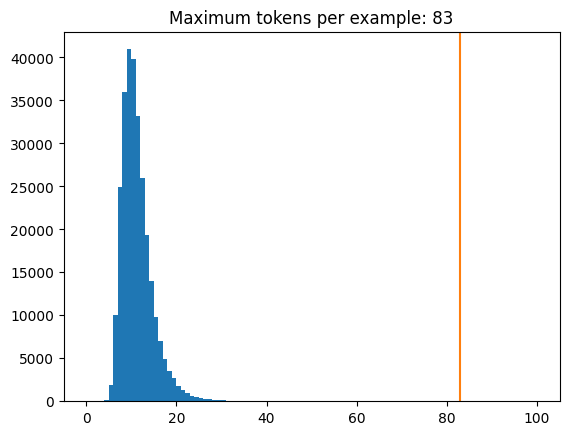

In [34]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 100, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [35]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', "'", 'i', 'you', 'to', 'the', '?', 'a']

The token IDs are padded with 0.

In [36]:
MAX_TOKENS=128
def process_dataset(context, target):
    context = tokenizers.fr.tokenize(context)
    context = context[:, :MAX_TOKENS]
    context = context.to_tensor()
    
    target = tokenizers.en.tokenize(target)
    target = target[:, :(MAX_TOKENS+1)]
    target_inputs = target[:, :-1].to_tensor()  # Drop the [END] tokens
    target_labels = target[:, 1:].to_tensor()   # Drop the [START] tokens
    return (context, target_inputs), target_labels

In [37]:
train_ds = train_raw.map(process_dataset, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_dataset, tf.data.AUTOTUNE)

In [38]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[  2  35  93  39 384   7   3   0   0   0]

[  2  17  54 254  35   7   0   0   0   0]
[ 17  54 254  35   7   3   0   0   0   0]


 # Transformer model

1. Embedding and positional encoding

In [39]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """

    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos/(10000.0**(2*i/d))
    
    return angles

In [40]:
def positional_encoding(length, depth):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.array([[int(k)] for k in range(length)]),
                            np.array([[int(k) for k in range(depth)]]),
                            depth)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return tf.cast(angle_rads, dtype=tf.float32)

(2048, 512)


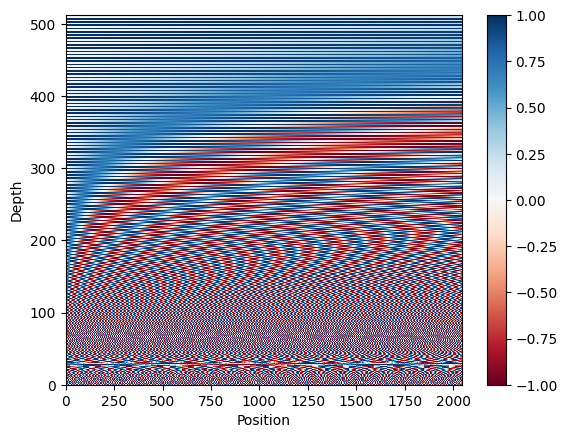

In [41]:
pos_encoding = positional_encoding(2048, 512)
# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [42]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [43]:
for (fr, en), en_labels in train_ds.take(1):
    break

print(fr.shape)
print(en.shape)
print(en_labels.shape)

(64, 30)
(64, 23)
(64, 23)


In [44]:
embed_fr = PositionalEmbedding(vocab_size=tokenizers.fr.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

fr_emb = embed_fr(fr)
en_emb = embed_en(en)

In [45]:
fr_emb._keras_mask

<tf.Tensor: shape=(64, 30), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [46]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 23), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

2. Layers

The base attention layer (helps make the global attention layer (encoder block), the causal attention layer (1st attention layer of the decoder block), and cross attention layer (2nd attention layer of decoder block))

In [47]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [48]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [49]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [50]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

The feed forward layer (encoder block and decoder block)

In [51]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
            ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

3. Encoder block

First the encoder layer

In [52]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

Then the encoder block

In [53]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

4. Decoder block 

First the decoder layer

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                   *,
                   d_model,
                   num_heads,
                   dff,
                   dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

Then the decoder block

In [55]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                 dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

5. The transformer

In [56]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
              del logits._keras_mask
        except AttributeError:
              pass

        # Return the final output and the attention weights.
        return logits

In [57]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [58]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.fr.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    dropout_rate=dropout_rate)

# Training

In [59]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [60]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [61]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [62]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [63]:
history = transformer.fit(train_ds,
                epochs=10,
                validation_data=val_ds)

Epoch 1/20
2196/2196 [==============================] - 231s 91ms/step - loss: 3.7403 - masked_accuracy: 0.4607 - val_loss: 2.0870 - val_masked_accuracy: 0.6392
Epoch 2/20
2196/2196 [==============================] - 166s 76ms/step - loss: 1.7759 - masked_accuracy: 0.6764 - val_loss: 1.4798 - val_masked_accuracy: 0.7200
Epoch 3/20
2196/2196 [==============================] - 167s 76ms/step - loss: 1.3575 - masked_accuracy: 0.7340 - val_loss: 1.2083 - val_masked_accuracy: 0.7615
Epoch 4/20
2196/2196 [==============================] - 164s 75ms/step - loss: 1.1361 - masked_accuracy: 0.7679 - val_loss: 1.0781 - val_masked_accuracy: 0.7835
Epoch 5/20
2196/2196 [==============================] - 167s 76ms/step - loss: 0.9976 - masked_accuracy: 0.7901 - val_loss: 1.0029 - val_masked_accuracy: 0.7960
Epoch 6/20
2196/2196 [==============================] - 165s 75ms/step - loss: 0.9075 - masked_accuracy: 0.8049 - val_loss: 0.9438 - val_masked_accuracy: 0.8071
Epoch 7/20
2196/2196 [============

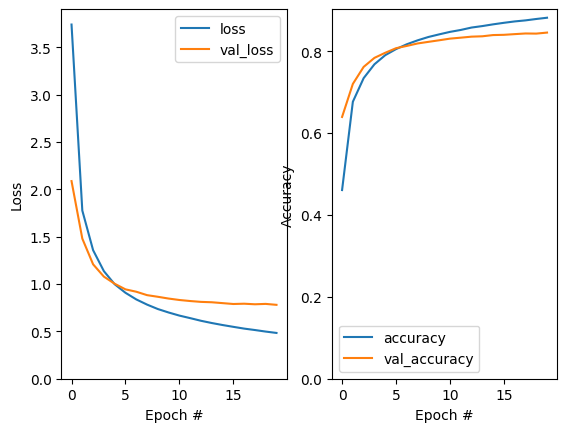

In [64]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

# Translate

In [65]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.fr.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [66]:
translator = Translator(tokenizers, transformer)

In [67]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [68]:
sentence = "J'irai acheter du pain à la boulangerie."
ground_truth = "I'll go buy bread at the bakery."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : J'irai acheter du pain à la boulangerie.
Prediction     : i will go buy bread from the bakery .
Ground truth   : I'll go buy bread at the bakery.


In [69]:
sentence = "C'est la première fois que je vais au cinéma."
ground_truth = "It's the first time that I go to the theater."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : C'est la première fois que je vais au cinéma.
Prediction     : this is the first time i ' m going to the movies .
Ground truth   : It's the first time that I go to the theater.


In [70]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [71]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([14, 14])

In [72]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.fr.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.fr.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(14,), dtype=string, numpy=
array([b'[START]', b'c', b"'", b'est', b'la', b'premiere', b'fois',
       b'que', b'je', b'vais', b'au', b'cinema', b'.', b'[END]'],
      dtype=object)>

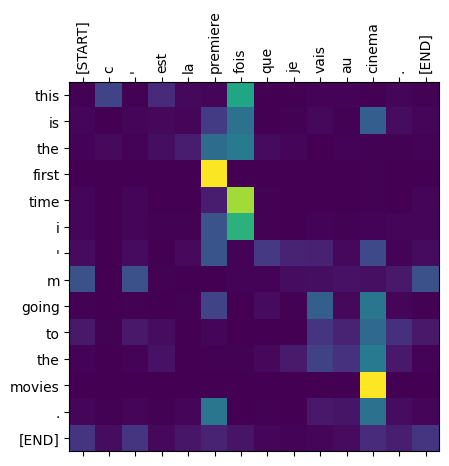

In [73]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [74]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.fr.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.fr.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

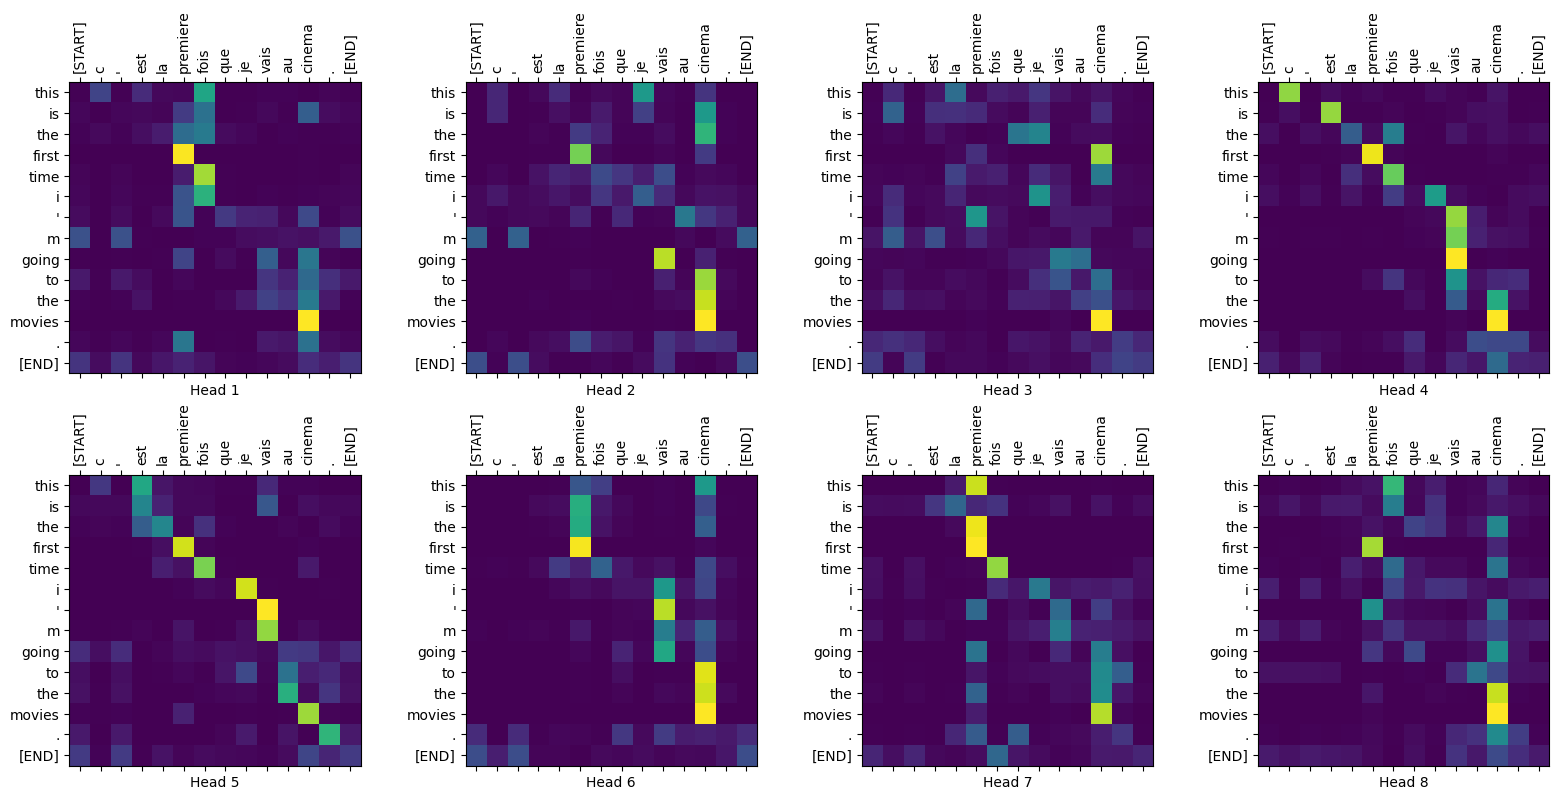

In [75]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

In [76]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
         tokens,
         attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

        return result

In [77]:
translator = ExportTranslator(translator)

In [78]:
tf.saved_model.save(translator, export_dir='translator_fr-en')

In [79]:
import shutil
shutil.make_archive('translator_fr-en', 'zip', 'translator_fr-en')

'/kaggle/working/translator_fr-en.zip'